# Optimal T5 for FOL2NS Translation
- Model: T5-large
- Method: 
  1. Add special symbols to T5Tokenizer
  2. Replace special symbols with corresponding natural words
  3. In validation stage, use "model.generate()" with "num_beams=5, repetition_penalty=1, no_repeat_ngram_size=2,max_length=64, early_stopping=True
  4. In test stage, use "model.generate()" with "num_beams=5, repetition_penalty=1, no_repeat_ngram_size=3, early_stopping=True, max_length=100"

In [4]:
from sklearn.model_selection import train_test_split
from math import ceil, log10
import os
from glob import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from collections import defaultdict
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

## Tokenizer

In [5]:
FOL2NS_dataset = pd.read_json(
    "FOL2NS.json",
    orient="records",
    lines=True
)

FOL2NW_with_predicate = pd.read_json(
    "FOL2NW_with_predicate.json",
    orient="records",
    lines=True
)

In [6]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-large")
model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-large").to("cuda:0")

In [7]:
symbol_ls = ['<¬>', '<∀>', '<∃>', '<⊕>', '<→>', '<∧>', '<∨>']
for i in symbol_ls:
    # check_tokenizer = tokenizer.encode(i, add_special_tokens=False)
    token_id = tokenizer.convert_tokens_to_ids(i)
    if token_id != tokenizer.unk_token_id:
        print(f"{i}: {token_id}")
    else:
        print("None")

None
None
None
None
None
None
None


In [8]:
tokenizer.add_tokens(['<¬>', '<∀>', '<∃>', '<⊕>', '<→>', '<∧>', '<∨>'])
model.resize_token_embeddings(len(tokenizer))

Embedding(32107, 1024)

In [9]:
print("Tokenizer length:", len(tokenizer))
for tok in symbol_ls:
    print(tok, "->", tokenizer.encode(tok, add_special_tokens=False))

Tokenizer length: 32107
<¬> -> [32100]
<∀> -> [32101]
<∃> -> [32102]
<⊕> -> [32103]
<→> -> [32104]
<∧> -> [32105]
<∨> -> [32106]


In [10]:
replace_dict = {
        '¬': 'No ',
        '∀': 'For All ', 
        '∃': 'There Exists ', 
        '⊕': 'XOR ', 
        '→': 'implies', 
        '∧':'and', 
        '∨':'or'
}

FOL2NS_dataset["input"] = FOL2NS_dataset["input"].apply(lambda x: x.translate(str.maketrans(replace_dict)))    

In [11]:
FOL2NS_dataset

,input,output
0,"No WantToBeAddictedTo(rina, caffeine) or (No A...",Rina doesn't want to be addicted to caffeine o...
1,"No WantToBeAddictedTo(rina, caffeine) XOR No ...",Rina eith doesn't want to be addicted to caffe...
2,"DrinkRegularly(rina, coffee) XOR IsUnawareTh...",Rina either regularly drinks coffee or is unaw...
3,(DoNotWantToBeAddictedToCaffeine(rina) XOR No...,If Rina either doesn't want to be addicted to ...
4,"Love(miroslav, music)",Miroslav Venhoda loved music.
...,...,...
3260,"BornIn(ailtonSilva, year1995) and CommonlyKnow...","Ailton Silva, born in 1995, is commonly known ..."
3261,"FootballPlayer(ailton) and LoanedTo(ailton, br...",Ailton is a football player who was loaned out...
3262,Brazilian(ailtonSilva) and Footballplayer(ailt...,Ailton Silva is a Brazilian footballer who pla...
3263,FootballClub(nautico) and FootballClub(braga),Náutico is a football club along with Braga.


In [12]:
FOL2NW_with_predicate

,FOL,FOL2NW
0,"∀ a ( A ( a ) ∧ ∀ b B ( b ) ⊕ ∃ c C ( c , d ) )",∀ a ( Mentors(a) ∧ ∀ district IsSpacious(distr...
1,"∀ a ( ¬ A ( a ) ⊕ ¬ B ( a , b ) ∨ ¬ C ( a , c ) )","∀ a ( ¬ Studies(a) ⊕ ¬ Develops(a, bicycle) ∨ ..."
2,"∀ a ( A ( a ) → ∀ b ( ¬ B ( b , c ) ∨ ¬ C ( b ...",∀ a ( HasOfficeIn(a) → ∀ chef ( ¬ LivesIn(chef...
3,∀ a A ( a ) → ∀ b ¬ B ( b ) ∧ ∀ c ¬ C ( c ),∀ a Follows(a) → ∀ architect ¬ IsThoughtful(ar...
4,"∀ a ( A ( a ) ∧ ∃ b ( ¬ B ( b ) ∨ ∃ c C ( c , ...",∀ a ( TravelsTo(a) ∧ ∃ man ( ¬ IsBusy(man) ∨ ∃...
...,...,...
3066,"∀ a ( A ( a ) ⊕ ∀ b ( ¬ B ( b ) ∧ C ( b , c ) ) )",∀ a ( IsRich(a) ⊕ ∀ strategist ( ¬ IsPoor(stra...
3067,∀ a ( A ( a ) → ∀ b ( B ( b ) ⊕ ∀ c C ( c ) ) ),∀ a ( IsSpacious(a) → ∀ photographer ( Influen...
3068,"A ( a ) ∨ B ( b , c )","IsSad(researcher) ∨ IsGenerous(pilot, c)"
3069,"∀ a ( A ( a ) ∨ ∀ b ( ¬ B ( b , c ) ⊕ ¬ C ( b ...",∀ a ( Mentors(a) ∨ ∀ institute ( ¬ IsArtist(in...


In [13]:
Train, Dev = train_test_split(FOL2NS_dataset, test_size=0.2, random_state=30, shuffle=True)
X_train, Y_train = Train['input'].tolist(), Train['output'].tolist()
X_dev, Y_dev = Dev['input'].tolist(), Dev['output'].tolist()

In [14]:
def tokenized_text(text):
  tokenization = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
  return tokenization.input_ids

x_train = tokenized_text(X_train)
y_train = tokenized_text(Y_train)
x_dev = tokenized_text(X_dev)
y_dev = tokenized_text(Y_dev)

y_train[y_train == tokenizer.pad_token_id] = -100
y_dev[y_dev == tokenizer.pad_token_id] = -100

## Training stage

In [15]:
def train(train_loader, model, optim, device="cuda"):
    model.train()
    train_loss = []

    for input_ids, labels in tqdm(train_loader, leave=False):
        optim.zero_grad()
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        
        pred_output = model(input_ids=input_ids, labels=labels)
       
        loss = pred_output.loss
        loss.backward()
        optim.step()

        train_loss.append(loss.item())

    return torch.tensor(train_loss).cpu()

In [16]:
def validate(dev_loader, model, ifgenerate=True, device="cuda"):
    model.eval()
    dev_loss = []
    token_list=[]
    text_list=[]

    with torch.no_grad():
        for input_dev_ids, dev_labels in tqdm(dev_loader, leave=False):
            input_dev_ids = input_dev_ids.to(device)
            dev_labels = dev_labels.to(device)
            
            output = model(input_ids=input_dev_ids, labels=dev_labels)
            dev_loss.append(output.loss.item())
            
            if ifgenerate:
                # generated_tokens = model.generate(input_dev_ids)
                generated_tokens = model.generate(
                                        input_dev_ids, 
                                        pad_token_id=tokenizer.pad_token_id, 
                                        eos_token_id=tokenizer.eos_token_id,
                                        num_beams=5,
                                        repetition_penalty=1, 
                                        no_repeat_ngram_size=2,
                                        max_length=64,
                                        early_stopping=True)

                generated_text = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
                for to in generated_tokens:
                    token_list.append(to.tolist())
                text_list.extend(generated_text)

    if ifgenerate:
        return sum(dev_loss) / len(dev_loss), token_list, text_list
    
    return sum(dev_loss) / len(dev_loss), None, None

In [17]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(x_train, y_train)
dev_dataset = TensorDataset(x_dev, y_dev)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1, pin_memory=True)
dev_loader = DataLoader(dev_dataset, batch_size=8, shuffle=False, num_workers=1, pin_memory=True)

In [18]:
def main(n_epochs, batch_size, lr, ifgenerate=True):
    optim = torch.optim.AdamW(model.parameters(), lr=lr)
    lr_string = abs(int(log10(lr)))
    
    train_losses = []
    dev_losses = []
    dev_tokens = []
    dev_text = []
    test_tokens = []
    test_text = []
    
    min_dev_loss = float("inf")
    last_epoch_with_dev_improvement = 0
    early_stopping_threshold = 50

    for epoch_n in tqdm(range(n_epochs)):
        train_loss = train(train_loader, model, optim)
        train_losses.append(train_loss.mean().item())
        
        if (epoch_n + 1) % 10 == 0:
            dev_loss, dev_token_list, dev_text_list = validate(dev_loader, model, ifgenerate)
            dev_losses.append(dev_loss)

            if ifgenerate:
                dev_tokens += dev_token_list
                dev_text.extend(dev_text_list)

            print(f'Epoch {epoch_n+1}, train loss: {train_loss.mean().item():.3f}, dev loss: {dev_loss:.3f}')

            if dev_loss < min_dev_loss:
                print('Saving the model')
                min_dev_loss = dev_loss
                last_epoch_with_dev_improvement = epoch_n

                for path in glob('*.pt'):
                    os.remove(path)
                torch.save(model.state_dict(), f'checkpoint_{batch_size}_{lr_string}.pt')
            else:
                if epoch_n - last_epoch_with_dev_improvement >= early_stopping_threshold:
                    print(f'Early stopping: no improvement for {early_stopping_threshold} epochs.')
                    break
          
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    
    plt.plot(dev_losses, label='Dev Loss')
    plt.xlabel("10x Epochs")
    plt.ylabel("Loss")
    plt.show()
    
    # test_tokens, test_texts = test(model, test_loader, device="cuda:1")
    
    if ifgenerate:
        return train_losses, dev_losses, dev_tokens, dev_text#, test_tokens, test_texts
    return train_losses, dev_losses, None, None#, test_tokens, test_texts

In [19]:
FOL2NW_with_predicate["FOL2NW"] = FOL2NW_with_predicate["FOL2NW"].apply(lambda x: x.translate(str.maketrans(replace_dict))) 

In [20]:
FOL2NW_with_predicate

,FOL,FOL2NW
0,"∀ a ( A ( a ) ∧ ∀ b B ( b ) ⊕ ∃ c C ( c , d ) )",For All a ( Mentors(a) and For All district ...
1,"∀ a ( ¬ A ( a ) ⊕ ¬ B ( a , b ) ∨ ¬ C ( a , c ) )",For All a ( No Studies(a) XOR No Develops(...
2,"∀ a ( A ( a ) → ∀ b ( ¬ B ( b , c ) ∨ ¬ C ( b ...",For All a ( HasOfficeIn(a) implies For All c...
3,∀ a A ( a ) → ∀ b ¬ B ( b ) ∧ ∀ c ¬ C ( c ),For All a Follows(a) implies For All archite...
4,"∀ a ( A ( a ) ∧ ∃ b ( ¬ B ( b ) ∨ ∃ c C ( c , ...",For All a ( TravelsTo(a) and There Exists ma...
...,...,...
3066,"∀ a ( A ( a ) ⊕ ∀ b ( ¬ B ( b ) ∧ C ( b , c ) ) )",For All a ( IsRich(a) XOR For All strategis...
3067,∀ a ( A ( a ) → ∀ b ( B ( b ) ⊕ ∀ c C ( c ) ) ),For All a ( IsSpacious(a) implies For All ph...
3068,"A ( a ) ∨ B ( b , c )","IsSad(researcher) or IsGenerous(pilot, c)"
3069,"∀ a ( A ( a ) ∨ ∀ b ( ¬ B ( b , c ) ⊕ ¬ C ( b ...",For All a ( Mentors(a) or For All institute ...


In [21]:
X_test = FOL2NW_with_predicate['FOL2NW'].tolist()
x_test = tokenized_text(X_test)

test_dataset = TensorDataset(x_test)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1, pin_memory=True)

In [30]:
torch.cuda.empty_cache()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 10, train loss: 0.081, dev loss: 0.943
Saving the model


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 20, train loss: 0.030, dev loss: 1.105


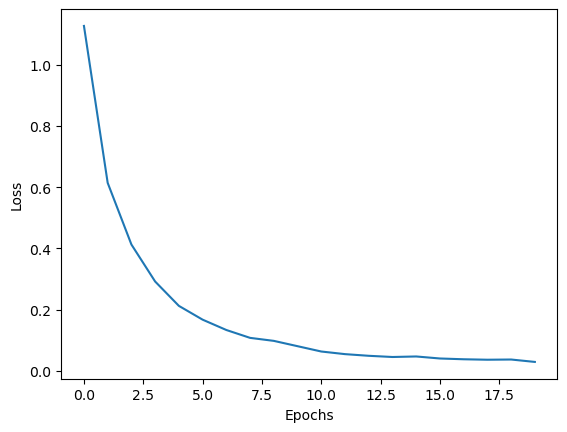

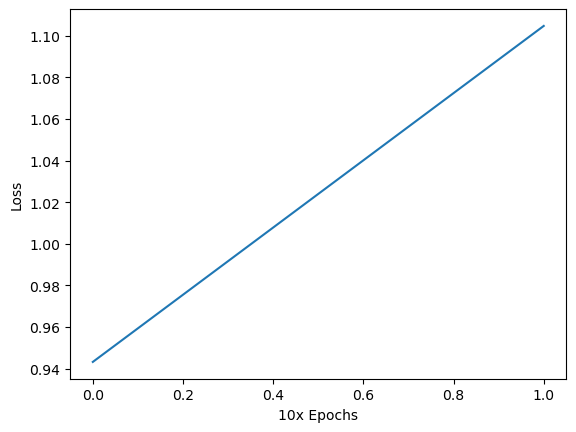

In [22]:
train_losses, dev_losses, dev_tokens, dev_text= main(n_epochs=20, batch_size=8, lr=10**(-4))

## Evaluation on Validation set

In [ ]:
input_text = X_dev
gold_text = Y_dev

In [ ]:
def minDistance(token1, token2):
    dp = [[0] * (len(token2)+1) for _ in range(len(token1)+1)]

    for i in range(len(token1)+1):
        dp[i][0]=i
    for j in range(len(token2)+1):
        dp[0][j]=j

    for i in range(1, len(token1)+1):
        for j in range(1, len(token2)+1):
            if token1[i-1] == token2[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                v1 = dp[i-1][j]
                v2 = dp[i][j-1]
                v3 = dp[i-1][j-1]
                min_value = min(v1, v2, v3)+1
                dp[i][j] = min_value

    return dp[len(token1)][len(token2)]

In [ ]:
def evaluation_with_minDistance(pred_dataset, gold_dataset, distance_fn, normalize=True, filter_empty=True):
    total_minDis = 0
    total_score = 0
    count = 0
    skipped = 0

    for pred, gold in zip(pred_dataset, gold_dataset):
        pred = str(pred).strip()
        gold = str(gold).strip()

        if filter_empty:
            if not pred or not gold or all(token in ["<pad>", ""] for token in pred.split()):
                skipped += 1
                continue

        dis = distance_fn(pred, gold)
        total_minDis += dis

        if normalize:
            base_len = max(len(pred.split()), len(gold.split()))
            score = dis / base_len if base_len > 0 else 0
            total_score += score
        else:
            total_score += dis

        count += 1

    avg_dist = total_minDis / count if count > 0 else float("inf")
    avg_score = total_score / count if count > 0 else float("inf")

    print(f"Total samples: {len(pred_dataset)}, evaluated: {count}, skipped: {skipped}")
    return avg_dist, avg_score

In [ ]:
def get_ngrams(sentence_toks,n):
  ngrams = defaultdict(int)  
  for i in range(0,len(sentence_toks)-(n-1)):
    ngrams[str.join(" ",sentence_toks[i:i+n])]+=1
  return(ngrams)

In [ ]:
def get_clipped_counts(h,r,n):
    counts = get_ngrams(h, n)
    reference_counts = get_ngrams(r, n)
    clipped_counts = [min(count, reference_counts[ngram]) for ngram, count in counts.items()]
    return sum(clipped_counts)/(sum(counts.values())+0.001)

In [ ]:
def compute_bleu(h, r, n):
    precisions = [get_clipped_counts(h, r, n) for n in range(1, n+1)]
    log_precisions = [np.log(p) if p > 0 else -9999 for p in precisions] 
    bleu = brevity_penalty(h, r) * np.exp(sum(log_precisions) / n)
    return bleu

In [ ]:
def brevity_penalty(h, r):
    return float(min(1,np.exp(1-len(r)/(len(h)+0.001))))

In [ ]:
def final_result(text, gold_text):
    avg_dist, avg_score = evaluation_with_minDistance(text, gold_text, minDistance, normalize=True)
    bleu_scores = [compute_bleu(h.split(), r.split(),1) for h, r in zip(text, gold_text)]
    print(f"Average Distance:{avg_dist}; Average Score:{avg_score}")
    print(f"Average BLEU:{sum(bleu_scores) / len(bleu_scores)}")

    print("\nThe first five samples:")
    for i in range(5):
        print("Input:", input_text[i])
        print("Output:", text[i])
        print("Target:", gold_text[i])
        print("Distance:", minDistance(text[i], gold_text[i]))
        print("BLEU:",compute_bleu(text[i], gold_text[i], 1),"\n")

In [28]:
final_result(dev_text, gold_text)

Total samples: 1306, evaluated: 652, skipped: 1
Average Distance:20.17484662576687; Average Score:1.459699179917049
Average BLEU:0.6693269301597455

The first five samples:
Input: No Musician(dan)
Output: Dan is not a musician.
Target: Dan is not a musician.
Distance: 0
BLEU: 0.9999545475205672 

Input: For All x For All y (Student(x) and GetGradeIn(x, a, englishClass) implies EnglishClassScore(x, y) and GreaterThan90(y) and LowerThan95(y)) 
Output: If a student gets an A in English class, then his score is greater than 90 and lower than 95.
Target: If a student gets an A in English class, then his score is greater than 90 but lower than 95.
Distance: 3
BLEU: 0.9677315297684971 

Input: There Exists x There Exists y(Act(x) and PreventsHarm(x) and (No (x=y)) and Act(y) and PreventsHarm(y))
Output: Some acts prevent harm.
Target: Some Acts prevent harmful things.
Distance: 11
BLEU: 0.6192690367626723 

Input: OperatedUntil(yMCA, campDavern, year2015)
Output: Camp Davern was operated by t

## Generating on Test set

In [23]:
def test(dataset, beam=5, penalty=1, no_repeat_ngram=3, max_len=100, device='cuda'):
    model.eval()
    test_token_list = []
    test_text_list = []
    
    dataset = torch.tensor(dataset).to(device)
    
    with torch.no_grad():
        for input_test_ids in tqdm(dataset,leave=False):

            test_generated_tokens = model.generate(
                                        input_ids=input_test_ids.unsqueeze(0),
                                        pad_token_id=tokenizer.pad_token_id,
                                        eos_token_id=tokenizer.eos_token_id,
                                        num_beams=beam,
                                        repetition_penalty=penalty,
                                        no_repeat_ngram_size=no_repeat_ngram,
                                        early_stopping=True,
                                        max_length=max_len
                                    )

            test_generated_text = tokenizer.batch_decode(test_generated_tokens, skip_special_tokens=True)

            for to in test_generated_tokens:
                test_token_list.append(to.tolist())  
            test_text_list.extend(test_generated_text)  

    return test_token_list, test_text_list

In [ ]:
torch.cuda.empty_cache()

In [33]:
test_token_list, test_text_list = test(x_test)

/tmp/ipykernel_45228/237760238.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = torch.tensor(dataset).to(device)


  0%|          | 0/3071 [00:00<?, ?it/s]

In [37]:
T5_Defined_FOL2NS = pd.DataFrame({
                            "FOL2NW": FOL2NW_text,
                            "T5_FOL2NS": test_text_list})
T5_Defined_FOL2NS

,FOL2NW,T5_FOL2NS
0,For All a ( Mentors(a) and For All district ...,Districts are either spacious or have a presid...
1,For All a ( No Studies(a) XOR No Develops(...,A person either studies or does not develop a ...
2,For All a ( HasOfficeIn(a) implies For All c...,"If the chef has an office in a building, then ..."
3,For All a Follows(a) implies For All archite...,"If a person follows a lead, then no architect ..."
4,For All a ( TravelsTo(a) and There Exists ma...,No man travels to another city if he is not bu...
...,...,...
3066,For All a ( IsRich(a) XOR For All strategis...,A person is either rich or a strategist is a s...
3067,For All a ( IsSpacious(a) implies For All ph...,"If a person is spacious, then either the photo..."
3068,"IsSad(researcher) or IsGenerous(pilot, c)","Pilot, c, is sad or generous."
3069,For All a ( Mentors(a) or For All institute ...,The institute either mentors young artists or ...


In [35]:
test_token_sample, test_text_sample = test(x_test[:10])

/tmp/ipykernel_45228/237760238.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = torch.tensor(dataset).to(device)


  0%|          | 0/10 [00:00<?, ?it/s]

In [34]:
FOL2NW_text = X_test

for i in range(10):
        print("FOL2NW:", FOL2NW_text[i])
        print("-->", test_text_list[i],"\n")

FOL2NW: For All  a ( Mentors(a) and For All  district IsSpacious(district) XOR  There Exists  president Mentors(president, specialist) )
--> Districts are either spacious or have a president mentor a specialist. 

FOL2NW: For All  a ( No  Studies(a) XOR  No  Develops(a, bicycle) or No  IsBasedIn(a, country) )
--> A person either studies or does not develop a bicycle, or they are not based in a country. 

FOL2NW: For All  a ( HasOfficeIn(a) implies For All  chef ( No  LivesIn(chef, zone) or No  IsThoughtful(chef) ) )
--> If the chef has an office in a building, then the chef neither lives in the zone nor is thoughtful. 

FOL2NW: For All  a Follows(a) implies For All  architect No  IsThoughtful(architect) and For All  lawyer No  Drives(lawyer)
--> If a person follows a lead, then no architect is thoughtful and no lawyer drives. 

FOL2NW: For All  a ( TravelsTo(a) and There Exists  man ( No  IsBusy(man) or There Exists  teacher Uses(teacher, car) ) )
--> No man travels to another city if 

In [38]:
# T5_Defined_FOL2NS.to_json(
#     "T5_Defined_FOL2NS.json",
#     orient="records",
#     lines=True,        
#     force_ascii=False
# )